# Constructing a rectangular version of image

In [1]:
import matplotlib.pyplot as plt

import numpy as np
from skbeam.core.image import construct_rphi_avg_image

%matplotlib notebook

In [2]:
# test construction of rphi
angles = np.linspace(0, 2*np.pi, 360)
radii = np.linspace(0, 800, 800)

ANGLES, RADII = np.meshgrid(angles, radii)

Z = np.cos(ANGLES*10)**2*RADII**2

mask = np.ones_like(Z)
mask[100:200] = 0
mask[:,100:200] = 0
mask[:,500:643] = 0
mask[70:130] = 0

Z_masked = Z*mask

Zproj = construct_rphi_avg_image(radii, angles, Z, dims=(800,800))
Zproj_masked = construct_rphi_avg_image(radii, angles, Z_masked, dims=(800,800),mask=mask)

<IPython.core.display.Javascript object>


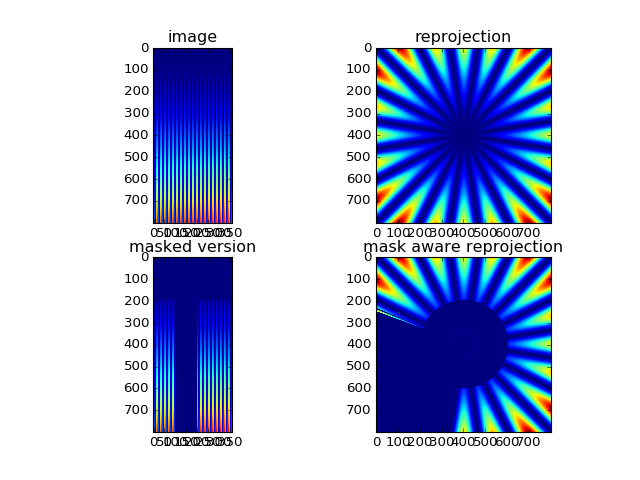

In [3]:
plt.figure(0);plt.clf()
plt.subplot(2,2,1).set_aspect("auto", adjustable="box");
plt.title("image")
plt.imshow(Z)
plt.subplot(2,2,2).set_aspect("equal")
plt.title("reprojection")
plt.imshow(Zproj)
plt.subplot(2,2,3).set_aspect("auto", adjustable="box")
plt.title("masked version")
plt.imshow(Z_masked)
plt.subplot(2,2,4).set_aspect("equal")
plt.title("mask aware reprojection")
plt.imshow(Zproj_masked)